In [13]:
# Setup: imports, style, paths
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

# Paths (edit if needed)
INPUT_PATH = r"C:\Users\OMEN\.cache\kagglehub\datasets\yasserh\titanic-dataset\versions\1\Titanic-Dataset.csv"
OUTPUT_PATH = r"C:\Users\OMEN\.cache\kagglehub\datasets\yasserh\titanic-dataset\versions\1\Titanic-Dataset-Cleaned.csv"
assert os.path.exists(INPUT_PATH), f"File not found: {INPUT_PATH}"


Shape: (891, 12)

Dtypes:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Null counts:
 Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64


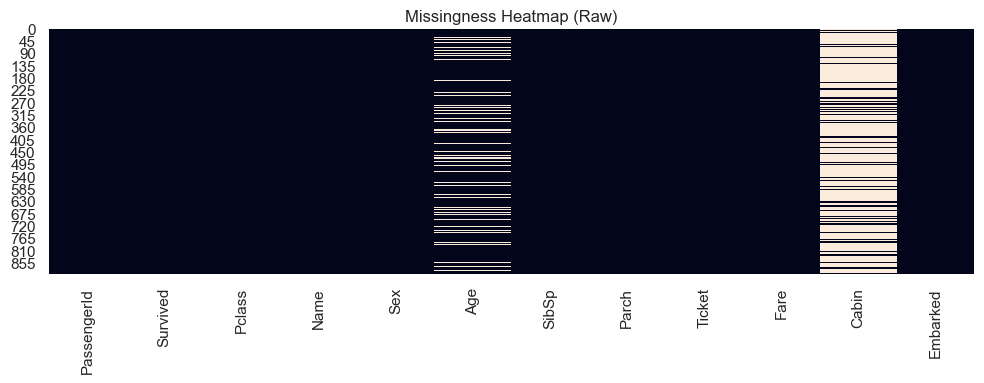

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [14]:
# 1) Import the dataset and explore basic info
df = pd.read_csv(INPUT_PATH)
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nNull counts:\n", df.isna().sum().sort_values(ascending=False))

# Visual: missingness heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missingness Heatmap (Raw)")
plt.tight_layout()
plt.show()

# Peek data
display(df.head(10))


Nulls after imputation:
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


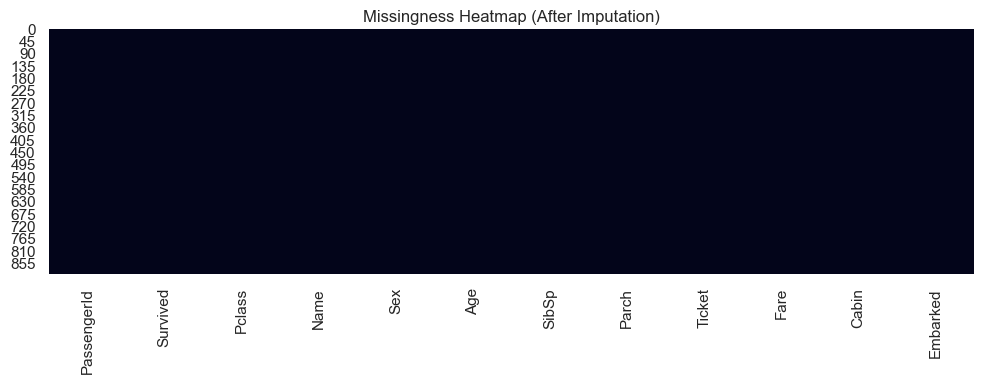

In [15]:
# 2) Handle missing values using mean/median/imputation
df_imp = df.copy()

num_cols = df_imp.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_imp.select_dtypes(include=["object", "category"]).columns.tolist()

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

if num_cols:
    df_imp[num_cols] = num_imputer.fit_transform(df_imp[num_cols])
if cat_cols:
    df_imp[cat_cols] = cat_imputer.fit_transform(df_imp[cat_cols])

print("Nulls after imputation:\n", df_imp.isna().sum().sort_values(ascending=False))

# Visual: missingness heatmap after imputation
plt.figure(figsize=(10, 4))
sns.heatmap(df_imp.isna(), cbar=False)
plt.title("Missingness Heatmap (After Imputation)")
plt.tight_layout()
plt.show()


In [17]:
# 3) Convert categorical features into numerical using encoding (One-Hot) — Corrected

from sklearn.preprocessing import OneHotEncoder

df_enc = df_imp.copy()

# Preserve identifiers/target if present
id_cols = [c for c in df_enc.columns if c.lower() in {"passengerid", "id"}]
target_cols = [c for c in df_enc.columns if c.lower() in {"survived", "target"}]
keep_cols = id_cols + target_cols

# Identify categorical and numeric feature columns
cat_cols = df_enc.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in df_enc.select_dtypes(include=[np.number]).columns if c not in keep_cols]

# Version-agnostic OneHotEncoder:
# - Do not pass deprecated 'sparse' argument.
# - Accept default (sparse) and convert to dense for DataFrame if needed.
ohe = OneHotEncoder(handle_unknown="ignore")

if cat_cols:
    ohe_arr = ohe.fit_transform(df_enc[cat_cols])
    # Convert to dense if the output is a sparse matrix
    if hasattr(ohe_arr, "toarray"):
        ohe_arr = ohe_arr.toarray()
    ohe_cols = ohe.get_feature_names_out(cat_cols)
    df_ohe = pd.DataFrame(ohe_arr, columns=ohe_cols, index=df_enc.index)
else:
    df_ohe = pd.DataFrame(index=df_enc.index)

# Concatenate: keep id/target, original numeric, and encoded categoricals
df_encoded = pd.concat([df_enc[keep_cols + num_cols], df_ohe], axis=1)

print("Encoded shape:", df_encoded.shape)
display(df_encoded.head(10))


Encoded shape: (891, 1731)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,"Name_Abbing, Mr. Anthony","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)",...,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,6.0,0.0,3.0,28.0,0.0,0.0,8.4583,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,7.0,0.0,1.0,54.0,0.0,0.0,51.8625,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,8.0,0.0,3.0,2.0,3.0,1.0,21.0750,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,9.0,1.0,3.0,27.0,0.0,2.0,11.1333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,10.0,1.0,2.0,14.0,1.0,0.0,30.0708,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


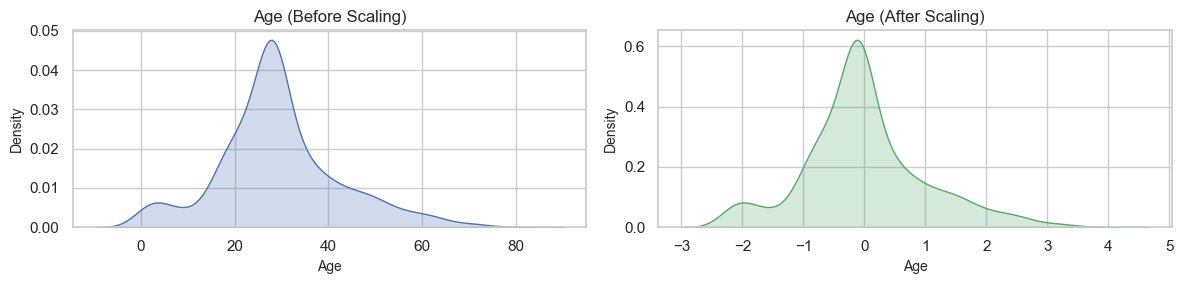

In [18]:
# 4) Normalize/standardize numerical features (StandardScaler)
df_scaled = df_encoded.copy()

# Re-identify columns (encoded dummies are already numeric; scale only original continuous numerics)
orig_num_cols = [c for c in num_cols if c in df_scaled.columns]
scaler = StandardScaler()

if orig_num_cols:
    df_scaled[orig_num_cols] = scaler.fit_transform(df_scaled[orig_num_cols])

# Visual: example distribution before vs after scaling (if Age exists)
if "Age" in df_encoded.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    sns.kdeplot(df_encoded["Age"], ax=axes[0], color="#4C72B0", fill=True)
    axes[0].set_title("Age (Before Scaling)")
    sns.kdeplot(df_scaled["Age"], ax=axes[1], color="#55A868", fill=True)
    axes[1].set_title("Age (After Scaling)")
    plt.tight_layout()
    plt.show()


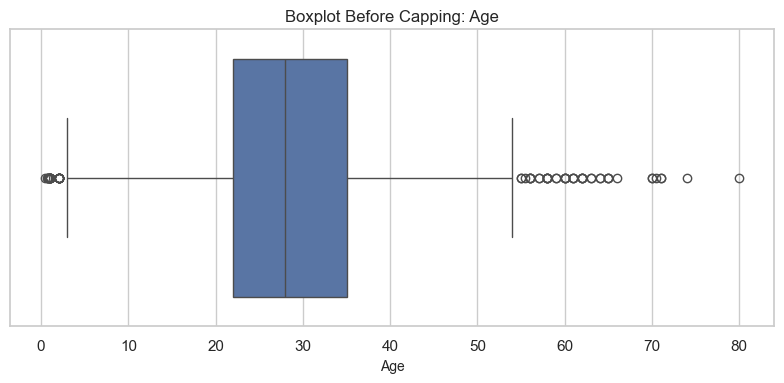

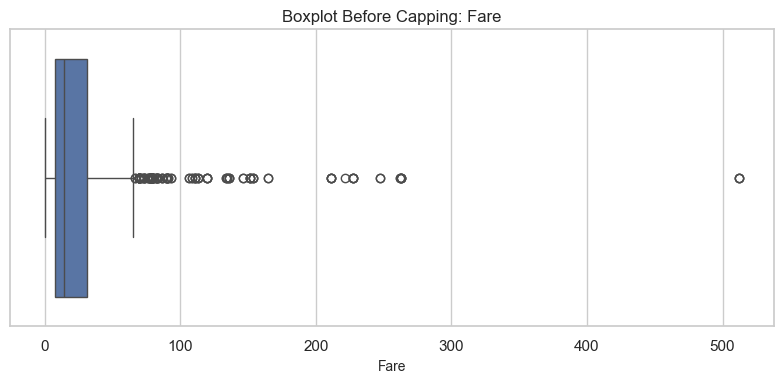

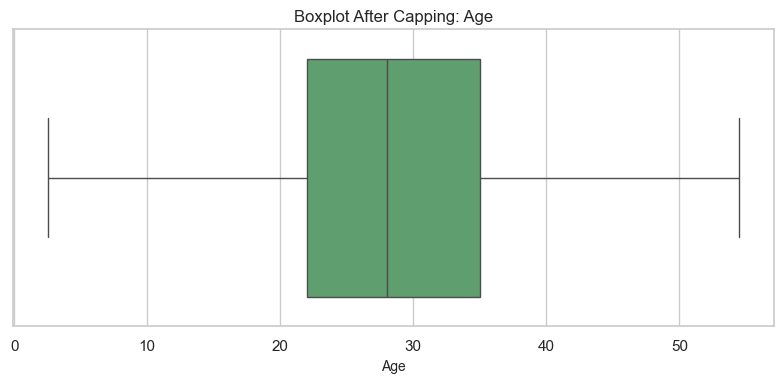

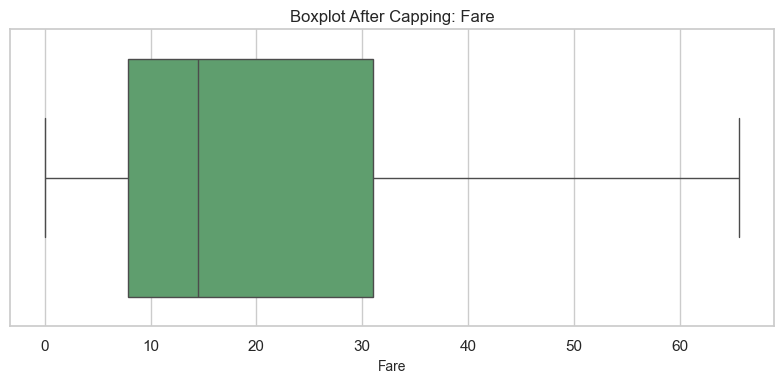

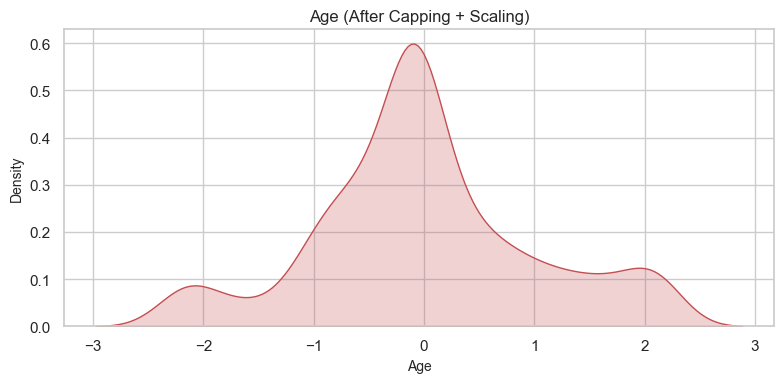

Final cleaned dataset saved to: C:\Users\OMEN\.cache\kagglehub\datasets\yasserh\titanic-dataset\versions\1\Titanic-Dataset-Cleaned.csv


In [20]:
# 5) Visualize outliers with boxplots and remove them (IQR capping on numeric features)

# Work on imputed values at original scale for meaningful IQR statistics
df_out = df_imp.copy()

# Numeric columns for outlier handling (exclude target if present)
num_cols_out = df_out.select_dtypes(include=[np.number]).columns.tolist()
num_cols_out = [c for c in num_cols_out if c.lower() not in {"survived", "target"}]

# Visual: before capping (prefer common continuous features; fallback to first two numerics)
cols_to_plot = [c for c in ["Age", "Fare"] if c in df_out.columns]
if not cols_to_plot:
    cols_to_plot = num_cols_out[:2]

for c in cols_to_plot:
    sns.boxplot(x=df_out[c], color="#4C72B0")
    plt.title(f"Boxplot Before Capping: {c}")
    plt.tight_layout()
    plt.show()

# Compute IQR bounds and cap (Tukey's 1.5*IQR fences)
bounds = {}
for col in num_cols_out:
    Q1, Q3 = df_out[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    bounds[col] = (lower, upper)
    df_out[col] = np.clip(df_out[col], lower, upper)

# Visual: after capping
for c in cols_to_plot:
    sns.boxplot(x=df_out[c], color="#55A868")
    plt.title(f"Boxplot After Capping: {c}")
    plt.tight_layout()
    plt.show()

# Rebuild final cleaned dataset:
# 1) Re-encode categoricals on df_out with version-agnostic OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_cols_out = df_out.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols_out = [c for c in df_out.select_dtypes(include=[np.number]).columns if c.lower() not in {"survived", "target"}]
id_cols_out = [c for c in df_out.columns if c.lower() in {"passengerid", "id"}]
target_cols_out = [c for c in df_out.columns if c.lower() in {"survived", "target"}]
keep_cols_out = id_cols_out + target_cols_out

ohe2 = OneHotEncoder(handle_unknown="ignore")  # no 'sparse'/'sparse_output' here
if cat_cols_out:
    ohe_arr2 = ohe2.fit_transform(df_out[cat_cols_out])
    if hasattr(ohe_arr2, "toarray"):  # convert sparse -> dense for DataFrame
        ohe_arr2 = ohe_arr2.toarray()
    ohe_cols2 = ohe2.get_feature_names_out(cat_cols_out)
    df_ohe2 = pd.DataFrame(ohe_arr2, columns=ohe_cols2, index=df_out.index)
else:
    df_ohe2 = pd.DataFrame(index=df_out.index)

df_encoded2 = pd.concat([df_out[keep_cols_out + num_cols_out], df_ohe2], axis=1)

# 2) Scale continuous numerics after capping
from sklearn.preprocessing import StandardScaler

orig_num_cols2 = [c for c in num_cols_out if c in df_encoded2.columns]
scaler2 = StandardScaler()
if orig_num_cols2:
    df_encoded2[orig_num_cols2] = scaler2.fit_transform(df_encoded2[orig_num_cols2])

# Visual: example KDE after capping+scaling
if "Age" in df_encoded2.columns:
    sns.kdeplot(df_encoded2["Age"], color="#C44E52", fill=True)
    plt.title("Age (After Capping + Scaling)")
    plt.tight_layout()
    plt.show()

# Save final cleaned dataset (uses OUTPUT_PATH defined earlier)
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
df_encoded2.to_csv(OUTPUT_PATH, index=False)
print("Final cleaned dataset saved to:", OUTPUT_PATH)
